In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from collections import Counter, namedtuple
import json
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from wordcloud import WordCloud
import textwrap
import torch.nn.functional as F
import re
from torchvision import transforms
import requests
import io
import textwrap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))
    break

In [2]:
import os
import pandas as pd
import re

# === CONFIG ===
CSV_PATH = "/kaggle/input/rsicd-image-caption-dataset/train.csv"   # path to your RSICD CSV file
OUTPUT_IMAGES_DIR = "images"     # output folder for images
OUTPUT_CAPTIONS_FILE = "captions.txt"

# === CAPTION CLEANING FUNCTION ===
def clean_caption(text):
    text = text.lower()
    # Remove all non-alphabetic characters except spaces
    text = re.sub(r"[^a-z ]+", '', text)
    # Remove extra spaces that might be created
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# === LOAD CSV ===
df = pd.read_csv(CSV_PATH)

# Create output folder if not exists
os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)

# Open captions.txt for writing
with open(OUTPUT_CAPTIONS_FILE, "w", encoding="utf-8") as f:
    f.write("image, caption\n")  # header same as Flickr8k format
    
    for idx, row in df.iterrows():
        filename = os.path.basename(row['filename'])
        
        # ---- FIX: Properly split captions ----
        captions_raw = row['captions'].strip()
        captions_raw = captions_raw.strip("[]")  # remove [ and ]
        captions = [c.strip() for c in captions_raw.split("'") if c.strip() and c.strip() != ',']
        # this will extract individual captions correctly
        
        img_bytes = row['image']
        
        # Save image
        if isinstance(img_bytes, str):  # if stored as string of bytes
            img_bytes = eval(img_bytes)['bytes']  # convert to dict then extract
        if isinstance(img_bytes, str):  # still str -> convert to bytes
            img_bytes = img_bytes.encode('latin1')
            
        with open(os.path.join(OUTPUT_IMAGES_DIR, filename), "wb") as img_file:
            img_file.write(img_bytes)
        
        # Write each caption on a new line with cleaning
        for caption in captions:
            caption = caption.replace("\n", " ")
            # Clean the caption: remove commas, convert to lowercase, keep only letters and spaces
            cleaned_caption = clean_caption(caption)
            f.write(f"{filename}, {cleaned_caption}\n")

print("✅ Conversion completed!")
print(f"Images saved in: {OUTPUT_IMAGES_DIR}")
print(f"Captions saved in: {OUTPUT_CAPTIONS_FILE}")

✅ Conversion completed!
Images saved in: images
Captions saved in: captions.txt


In [3]:
IMAGE_DIR = "/kaggle/working/images"
CAPTIONS_FILE = "/kaggle/working/captions.txt"

# Load captions (CSV format)
captions = {}
with open(CAPTIONS_FILE, 'r') as f:
    next(f)  # skip header line
    for line in f:
        img, caption = line.strip().split(',', 1)  # split only on first comma
        captions.setdefault(img, []).append(caption)

# Show sample
print("Example image:", list(captions.keys())[0])
print("Captions:", captions[list(captions.keys())[0]])
print("Total images:", len(captions))

Example image: airport_1.jpg
Captions: [' many aircraft are parked next to a long building in an airport', ' many planes are parked next to a long building at an airport', ' many planes are parked next to a long building in an airport', ' many planes are parked next to a long building at an airport', ' many planes are parked next to a long building in an airport']
Total images: 8734


In [4]:
image_path = '/kaggle/working/images'
data = pd.read_csv('/kaggle/working/captions.txt')
print(data.head())

           image                                            caption
0  airport_1.jpg   many aircraft are parked next to a long build...
1  airport_1.jpg   many planes are parked next to a long buildin...
2  airport_1.jpg   many planes are parked next to a long buildin...
3  airport_1.jpg   many planes are parked next to a long buildin...
4  airport_1.jpg   many planes are parked next to a long buildin...


Available columns in your DataFrame:
['image', ' caption']

First few rows:
           image                                            caption
0  airport_1.jpg   many aircraft are parked next to a long build...
1  airport_1.jpg   many planes are parked next to a long buildin...
2  airport_1.jpg   many planes are parked next to a long buildin...
3  airport_1.jpg   many planes are parked next to a long buildin...
4  airport_1.jpg   many planes are parked next to a long buildin...
Found caption column with extra spaces: ' caption' -> renaming to 'caption'

Using columns: image='image', caption='caption'

Visualization of random images with captions:


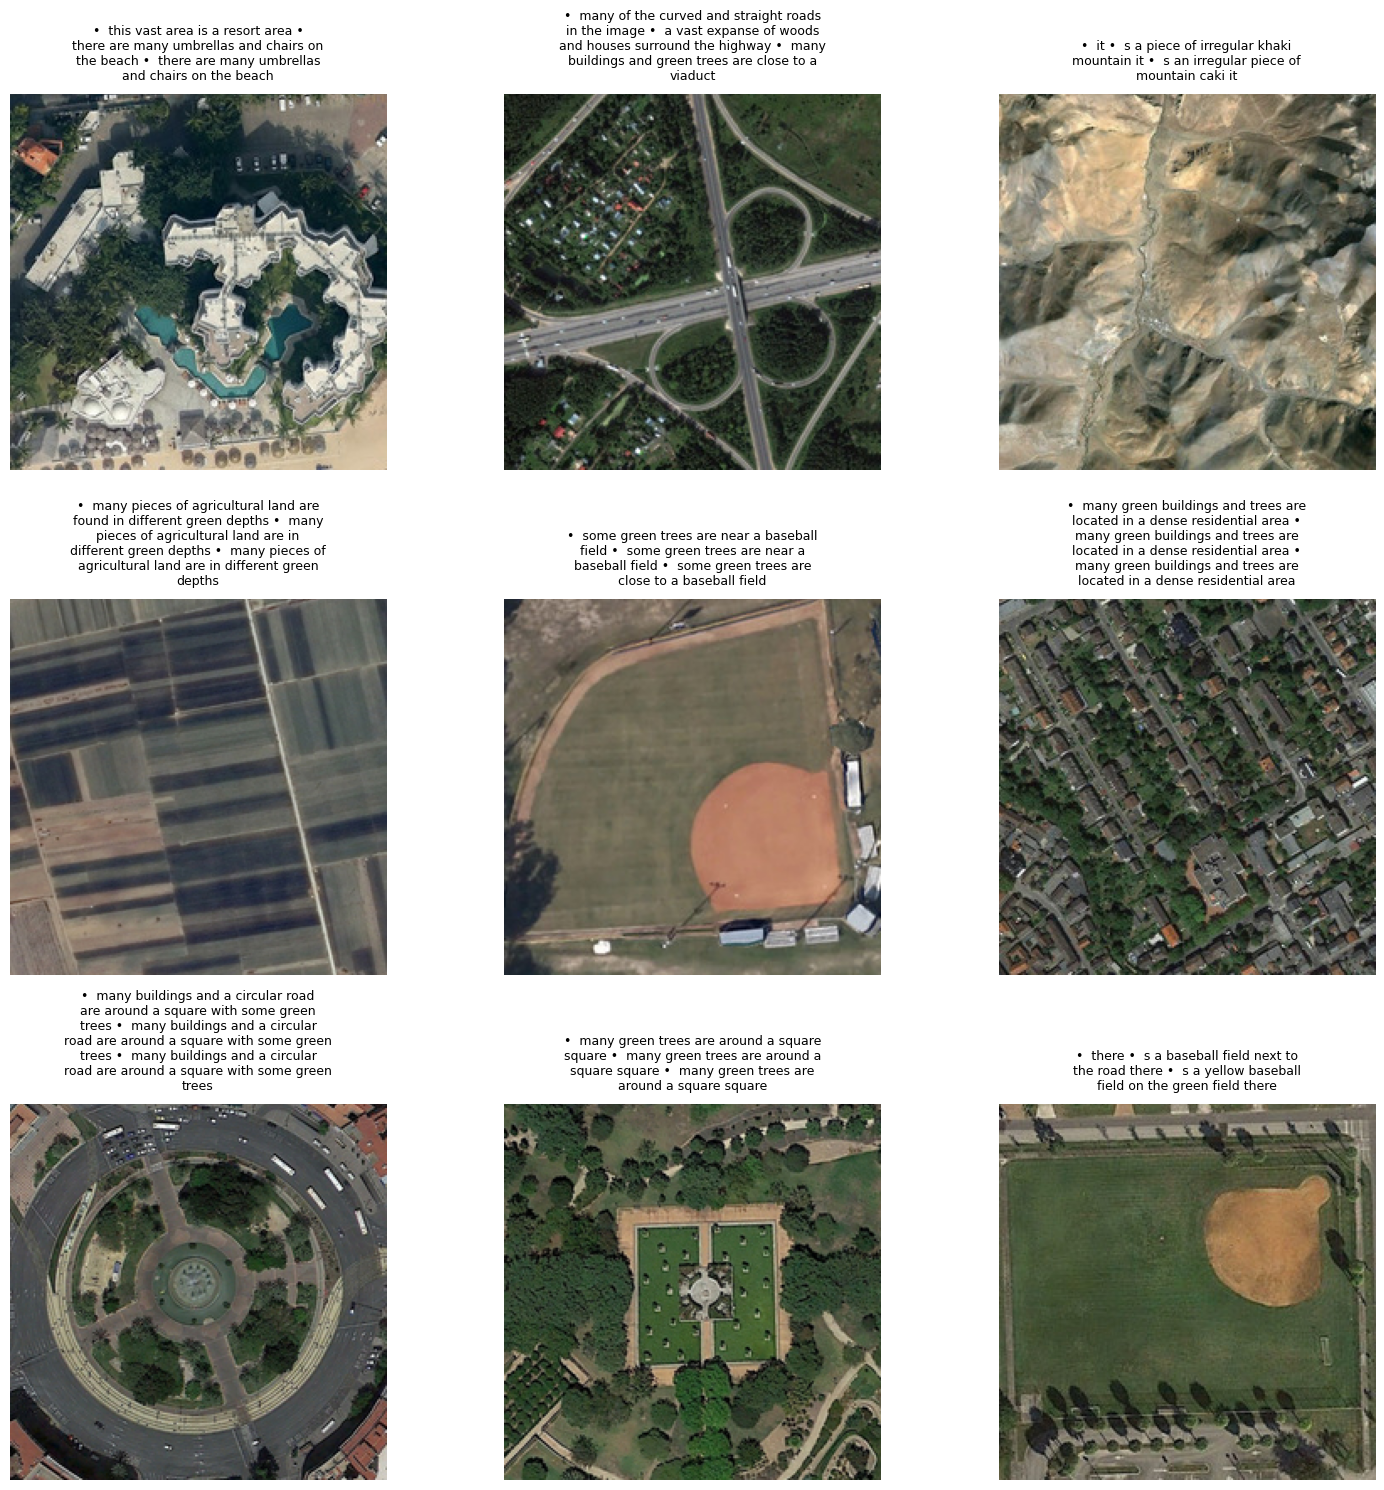

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import os
from textwrap import wrap

# First, let's check what columns are available in your DataFrame
print("Available columns in your DataFrame:")
print(data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

# Function to display images with their corresponding captions
def display_images_with_captions(dataframe, num_images=9, img_size=224, image_col='image', caption_col='caption'):
    """
    Displays images with their corresponding captions
    
    Parameters:
    dataframe - DataFrame containing the data
    num_images - number of images to display
    img_size - size of the image to display
    image_col - name of the column containing image filenames
    caption_col - name of the column containing captions
    """
    plt.figure(figsize=(15, 15))
    
    # Get unique images (since each image might have multiple captions)
    unique_images = dataframe.drop_duplicates(subset=[image_col]).sample(min(num_images, len(dataframe.drop_duplicates(subset=[image_col]))))
    
    for i, (_, row) in enumerate(unique_images.iterrows(), 1):
        plt.subplot(3, 3, i)
        
        try:
            # Load the image
            img = Image.open(os.path.join(image_path, row[image_col]))
            img = img.resize((img_size, img_size))
            
            plt.imshow(img)
            
            # Get all captions for this image
            all_captions = dataframe[dataframe[image_col] == row[image_col]][caption_col].tolist()
            caption_text = "\n".join([f"• {cap}" for cap in all_captions[:3]])  # Show first 3 captions
            
            # Add caption with line breaks
            plt.title("\n".join(wrap(caption_text, 40)), fontsize=9, pad=10)
            plt.axis('off')
            
        except Exception as e:
            print(f"Error loading image {row[image_col]}: {e}")
            plt.text(0.5, 0.5, f"Error loading\n{row[image_col]}", 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Try to determine the correct column names and call the function
# Common possibilities for column names:
possible_image_cols = ['image', 'filename', 'image_name', 'img']
possible_caption_cols = ['caption', 'captions', 'text', 'description']

image_col = None
caption_col = None

# Find the correct image column
for col in possible_image_cols:
    if col in data.columns:
        image_col = col
        break

# Find the correct caption column  
for col in possible_caption_cols:
    if col in data.columns:
        caption_col = col
        break

# Also check for columns with leading/trailing spaces
if not caption_col:
    for col in data.columns:
        if 'caption' in col.strip().lower():
            caption_col = col
            break

# Clean up column names if they have spaces
if caption_col and caption_col.strip() != caption_col:
    print(f"Found caption column with extra spaces: '{caption_col}' -> renaming to 'caption'")
    data = data.rename(columns={caption_col: 'caption'})
    caption_col = 'caption'

if image_col and caption_col:
    print(f"\nUsing columns: image='{image_col}', caption='{caption_col}'")
    print("\nVisualization of random images with captions:")
    display_images_with_captions(data, num_images=9, image_col=image_col, caption_col=caption_col)
else:
    print(f"Could not find appropriate columns. Found image column: {image_col}, caption column: {caption_col}")
    print("Please specify the correct column names manually.")

In [6]:
import pandas as pd

# Load the captions file
df = pd.read_csv("/kaggle/working/captions.txt")

# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Save the cleaned version
df.to_csv("/kaggle/working/captions.txt", index=False)

print("Fixed column names in captions.txt")
print(f"Columns are now: {df.columns.tolist()}")

Fixed column names in captions.txt
Columns are now: ['image', 'caption']


### config

In [7]:
class Config:
    img_dir = "/kaggle/working/images"
    caption_file = "/kaggle/working/captions.txt"
    glove_file = "/kaggle/input/glove6b300dtxt/glove.6B.300d.txt"
    
    max_caption_length = 50
    embed_size = 300
    attention_size = 512
    hidden_size = 512
    num_layers = 1
    dropout = 0.3
    
    finetune_encoder = True
    batch_size = 64
    num_epochs = 40  
    learning_rate = 1e-4  
    lr_decay_patience = 3
    grad_clip = 5.0
    vocab_threshold = 5
    teacher_forcing_start = 1.0
    teacher_forcing_end = 0.5
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### vocab and text cleaning

In [8]:
def clean_caption(caption):
    text = caption.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.idx = 4

    def build_vocab(self, captions, threshold=5):
        counter = Counter()
        for caption in captions:
            tokens = caption.split()
            counter.update(tokens)
        words = [word for word, cnt in counter.items() if cnt >= threshold]
        for word in words:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = text.split()
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]

### dataset

In [9]:
class FlickrDataset(Dataset):
    def __init__(self, img_dir, captions_dict, img_list, vocab, transform=None):
        self.img_dir, self.captions_dict, self.img_list, self.vocab, self.transform = \
            img_dir, captions_dict, img_list, vocab, transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        caption = random.choice(self.captions_dict[img_name])
        tokens = [self.vocab.word2idx["<START>"]]
        tokens.extend(self.vocab.encode(caption))
        tokens.append(self.vocab.word2idx["<END>"])

        padded_tokens = torch.zeros(Config.max_caption_length, dtype=torch.long)
        cap_len = min(len(tokens), Config.max_caption_length)
        padded_tokens[:cap_len] = torch.tensor(tokens)[:cap_len]
        return img, padded_tokens, cap_len

### model architecture (with Attention)

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, finetune=False):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.feature_dim = resnet.fc.in_features

        for param in self.resnet.parameters():
            param.requires_grad = False

        if finetune:
            print("Encoder finetuning enabled.")
            for c in list(self.resnet.children())[6:]:
                for p in c.parameters():
                    p.requires_grad = True

    def forward(self, images):
        features = self.resnet(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, self.feature_dim)
        return features

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim, attention_size, pretrained_embeddings=None):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.embed = nn.Embedding(vocab_size, embed_size)
        if pretrained_embeddings is not None:
            self.embed.from_pretrained(pretrained_embeddings, freeze=True)

        self.attention = Attention(encoder_dim, hidden_size, attention_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.init_h = nn.Linear(encoder_dim, hidden_size)
        self.init_c = nn.Linear(encoder_dim, hidden_size)
        self.f_beta = nn.Linear(hidden_size, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        encoder_out_flat = encoder_out.view(batch_size, -1, self.encoder_dim)
        embeddings = self.embed(encoded_captions)
        mean_encoder_out = encoder_out_flat.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)

        decode_lengths = [c - 1 for c in caption_lengths]
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(Config.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), encoder_out_flat.size(1)).to(Config.device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out_flat[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(h)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas

### training and evaluation

In [11]:
def train_epoch(encoder, decoder, dataloader, criterion, optimizer, device, grad_clip):
    encoder.train(); decoder.train()
    total_loss = 0
    for imgs, captions, cap_lens in tqdm(dataloader, desc="Training Epoch", leave=False):
        imgs, captions = imgs.to(device), captions.to(device)
        scores, caps_sorted, decode_lengths, alphas = decoder(encoder(imgs), captions, cap_lens)
        targets = caps_sorted[:, 1:]
        scores = nn.utils.rnn.pack_padded_sequence(scores, decode_lengths, batch_first=True, enforce_sorted=False).data
        targets = nn.utils.rnn.pack_padded_sequence(targets, decode_lengths, batch_first=True, enforce_sorted=False).data
        loss = criterion(scores, targets)
        optimizer.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(list(filter(lambda p: p.requires_grad, decoder.parameters())) +
                                     list(filter(lambda p: p.requires_grad, encoder.parameters())),
                                     grad_clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

### data loading and main

In [12]:
def load_and_clean_captions(caption_file):
    print("Loading and cleaning captions...")
    captions_dict = {}
    with open(caption_file, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            tokens = line.strip().split(',', 1)
            if len(tokens) != 2: continue
            img_id, caption = tokens[0], tokens[1]
            if img_id not in captions_dict: captions_dict[img_id] = []
            captions_dict[img_id].append(clean_caption(caption))
    print("Captions loaded and cleaned.")
    return captions_dict

def load_glove_embeddings(glove_file, vocab, embed_size):
    if not os.path.exists(glove_file):
        print(f"GloVe file not found at: {glove_file}"); return None
    print("Loading GloVe embeddings...")
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Reading GloVe file"):
            values = line.split()
            word, coefs = values[0], np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((len(vocab), embed_size))
    for word, i in vocab.word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    print("GloVe embeddings loaded.")
    return torch.from_numpy(embedding_matrix).float()

def create_splits(captions_dict, train_ratio=0.8, val_ratio=0.1):
    img_list = list(captions_dict.keys())
    random.seed(42); random.shuffle(img_list)
    train_end = int(len(img_list) * train_ratio)
    val_end = train_end + int(len(img_list) * val_ratio)
    return img_list[:train_end], img_list[train_end:val_end], img_list[val_end:]

def main():
    cfg = Config()
    history = {'train_loss': [], 'val_bleu': [], 'bleu_epochs': []}
    print(f"Using device: {cfg.device}")

    captions_dict = load_and_clean_captions(cfg.caption_file)
    train_imgs, val_imgs, _ = create_splits(captions_dict)

    all_captions = [cap for caps_list in captions_dict.values() for cap in caps_list]
    vocab = Vocabulary(); vocab.build_vocab(all_captions, cfg.vocab_threshold)
    print(f"Vocabulary size: {len(vocab)}")

    glove_weights = load_glove_embeddings(cfg.glove_file, vocab, cfg.embed_size)

    transform = transforms.Compose([
        transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_dataset = FlickrDataset(cfg.img_dir, captions_dict, train_imgs, vocab, transform)
    val_dataset = FlickrDataset(cfg.img_dir, captions_dict, val_imgs, vocab, transform)

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

    encoder = EncoderCNN(finetune=cfg.finetune_encoder).to(cfg.device)
    decoder = DecoderLSTMWithAttention(cfg.embed_size, cfg.hidden_size, len(vocab), encoder.feature_dim,
                                       cfg.attention_size, pretrained_embeddings=glove_weights).to(cfg.device)

    params = list(filter(lambda p: p.requires_grad, decoder.parameters())) + \
             list(filter(lambda p: p.requires_grad, encoder.parameters()))
    optimizer = optim.Adam(params, lr=cfg.learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    print("Starting training...")
    for epoch in range(cfg.num_epochs):
        train_loss = train_epoch(encoder, decoder, train_loader, criterion, optimizer, cfg.device, cfg.grad_clip)
        history['train_loss'].append(train_loss)
        scheduler.step(train_loss)
        tqdm.write(f"Epoch [{epoch+1}/{cfg.num_epochs}] Loss: {train_loss:.4f}")

    print(f"\nTraining complete!")
    torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict(), 'vocab': vocab}, 'best_attention_model.pth')
    print("Model saved as 'best_attention_model.pth'")
    with open('training_history_attention.json', 'w') as f: json.dump(history, f)
    print("Training history saved.")


### visualizations and generation for attention model

In [13]:
def generate_caption_with_attention(encoder, decoder, img_tensor, vocab):
    """Generates a caption, accepting loaded model objects."""
    with torch.no_grad():
        encoder_out = encoder(img_tensor)
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(1, -1, encoder_dim)
        
        h = decoder.init_h(encoder_out.mean(dim=1))
        c = decoder.init_c(encoder_out.mean(dim=1))
        
        prev_word = torch.LongTensor([vocab.word2idx['<START>']]).to(Config.device)
        
        seq = []
        for _ in range(Config.max_caption_length):
            embeddings = decoder.embed(prev_word)
            awe, _ = decoder.attention(encoder_out, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            awe = gate * awe
            h, c = decoder.lstm(torch.cat([embeddings, awe], dim=1), (h, c))
            scores = decoder.fc(h)
            _, next_word_idx = torch.max(scores, dim=1)
            
            if next_word_idx.item() == vocab.word2idx['<END>']:
                break
            
            word = vocab.idx2word.get(next_word_idx.item(), vocab.idx2word[vocab.word2idx['<UNK>']])
            seq.append(word)
            prev_word = next_word_idx
            
    return ' '.join(seq)
    
def show_qualitative_results_attention(encoder, decoder, vocab, img_list, img_dir, captions_dict, num_samples=5):
    """Displays results, accepting loaded model objects."""
    print(f"\nDisplaying qualitative results for {num_samples} random images...")
    random_images = random.sample(img_list, num_samples)
    
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)
        img_tensor = transforms.Compose([
            transforms.Resize((224, 224)), transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])(img).unsqueeze(0).to(Config.device)
        
        generated_caption = generate_caption_with_attention(encoder, decoder, img_tensor, vocab)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        print("-" * 80)
        print(f"IMAGE: {img_name}")
        print(f"GENERATED CAPTION:\n  {generated_caption}\n")
        
        reference_captions = captions_dict[img_name]
        print("REFERENCE CAPTIONS:")
        for ref_cap in reference_captions:
            print(f"  - {ref_cap}")
        print("-" * 80)
        print("\n")


def plot_training_results(history_file):
    try:
        with open(history_file, 'r') as f:
            history = json.load(f)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        if 'train_loss' in history and history['train_loss']:
            ax1.plot(history['train_loss'], label='Training Loss', color='deepskyblue')
            ax1.set_title('Training Loss per Epoch')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, linestyle='--', alpha=0.6)
        else:
            ax1.text(0.5, 0.5, 'No training loss data.', ha='center')

        if 'val_bleu' in history and history['val_bleu']:
            ax2.plot(history['bleu_epochs'], history['val_bleu'], label='Validation BLEU-4', color='tomato', marker='o')
            ax2.set_title('Validation BLEU-4 Score')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('BLEU-4 Score')
            ax2.legend()
            ax2.grid(True, linestyle='--', alpha=0.6)
            ax2.set_xticks(history['bleu_epochs'])
        else:
            ax2.text(0.5, 0.5, 'No BLEU score data.', ha='center')

        plt.suptitle('Training Process Analysis', fontsize=16, weight='bold')
        plt.show()

    except FileNotFoundError:
        print(f"Error: History file not found at '{history_file}'")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from the history file '{history_file}'")

In [14]:
def calculate_bleu_on_validation_set(encoder, decoder, vocab, img_list, img_dir, captions_dict):
    """Calculates BLEU-4 score on the entire validation set."""
    print("\nCalculating BLEU-4 score on the full validation set...")
    
    references = []
    hypotheses = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for img_name in tqdm(img_list, desc="Generating captions for BLEU score"):
        img_path = os.path.join(img_dir, img_name)
        img_tensor = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(Config.device)
        
        # Get reference captions (and tokenize them)
        actual_caps = [cap.split() for cap in captions_dict[img_name]]
        references.append(actual_caps)
        
        # Generate hypothesis
        generated_cap = generate_caption_with_attention(encoder, decoder, img_tensor, vocab)
        hypotheses.append(generated_cap.split())

    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    print(f"\n--- FINAL BLEU-4 SCORE ON VALIDATION SET: {bleu4:.4f} ---")
    return bleu4

###  training

In [15]:
main()
print("\nTRAINING COMPLETE")

Using device: cuda
Loading and cleaning captions...
Captions loaded and cleaned.
Vocabulary size: 1103
Loading GloVe embeddings...


Reading GloVe file: 400000it [00:31, 12532.68it/s]


GloVe embeddings loaded.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Encoder finetuning enabled.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...


Epoch [1/40] Loss: 5.1666


Epoch [2/40] Loss: 4.2362


Epoch [3/40] Loss: 3.6868


Epoch [4/40] Loss: 3.3565


Epoch [5/40] Loss: 3.1173


Epoch [6/40] Loss: 2.9582


Epoch [7/40] Loss: 2.8259


Epoch [8/40] Loss: 2.7206


Epoch [9/40] Loss: 2.6806


Epoch [10/40] Loss: 2.5847


Epoch [11/40] Loss: 2.5102


Epoch [12/40] Loss: 2.4417


Epoch [13/40] Loss: 2.3887


Epoch [14/40] Loss: 2.3184


Epoch [15/40] Loss: 2.2796


Epoch [16/40] Loss: 2.2540


Epoch [17/40] Loss: 2.2183


Epoch [18/40] Loss: 2.1799


Epoch [19/40] Loss: 2.1574


Epoch [20/40] Loss: 2.1130


Epoch [21/40] Loss: 2.0906


Epoch [22/40] Loss: 2.0489


Epoch [23/40] Loss: 2.0303


Epoch [24/40] Loss: 1.9895


Epoch [25/40] Loss: 1.9807


Epoch [26/40] Loss: 1.9833


Epoch [27/40] Loss: 1.9238


Epoch [28/40] Loss: 1.9026


Epoch [29/40] Loss: 1.9020


Epoch [30/40] Loss: 1.8804


Epoch [31/40] Loss: 1.8352


Epoch [32/40] Loss: 1.8366


Epoch [33/40] Loss: 1.8290


Epoch [34/40] Loss: 1.8024


Epoch [35/40] Loss: 1.7964


Epoch [36/40] Loss: 1.7816


Epoch [37/40] Loss: 1.7799


Epoch [38/40] Loss: 1.7584


Epoch [39/40] Loss: 1.7423


Epoch [40/40] Loss: 1.7388

Training complete!
Model saved as 'best_attention_model.pth'
Training history saved.

TRAINING COMPLETE


### analysis & visualization

Loading and cleaning captions...
Captions loaded and cleaned.

Displaying training process chart...


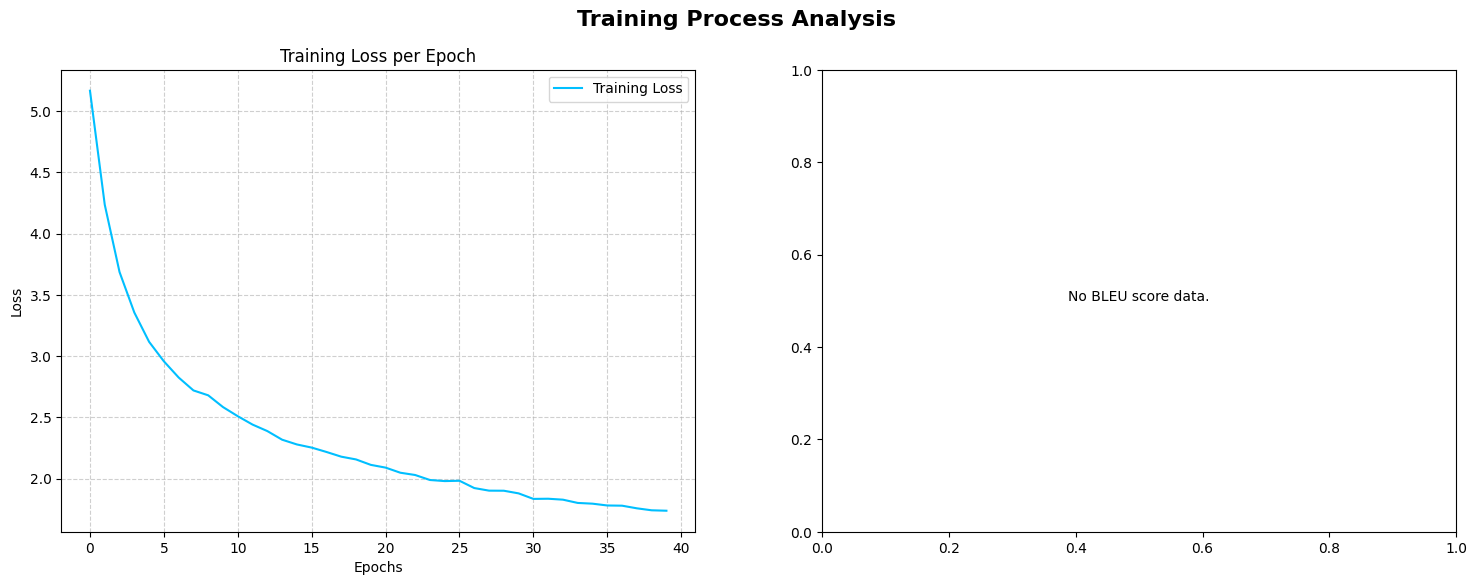


Loading trained model from checkpoint...
Model loaded successfully.

Displaying qualitative results for 5 random images...


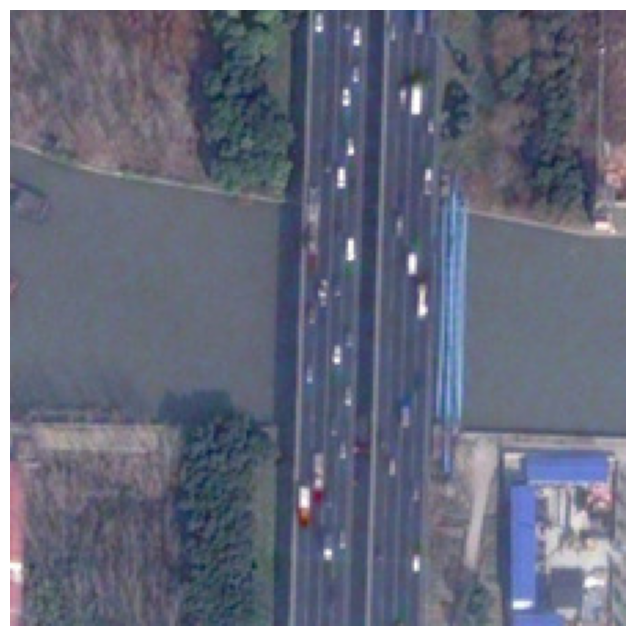

--------------------------------------------------------------------------------
IMAGE: bridge_150.jpg
GENERATED CAPTION:
  several parallel roads are located on a river with some green trees on two sides of it

REFERENCE CAPTIONS:
  - many cars are located on two parallel bridges above a river with some green trees and several buildings
  - many cars are located on two parallel bridges over a river with some green trees and several buildings
  - many cars are on two parallel bridges on a river with some green trees and different buildings
  - many cars are on two parallel bridges over a river with some green trees and several buildings
  - many cars are on two parallel bridges over a river with some green trees and several buildings
--------------------------------------------------------------------------------




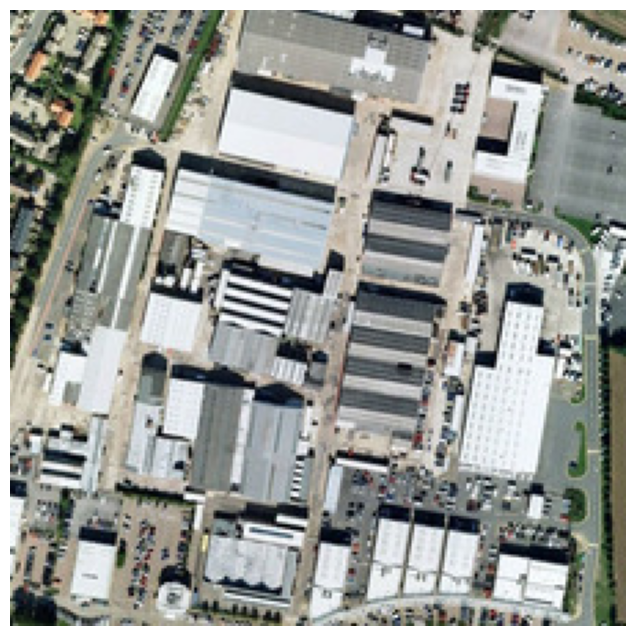

--------------------------------------------------------------------------------
IMAGE: industrial_333.jpg
GENERATED CAPTION:
  the factory buildings are in the factory

REFERENCE CAPTIONS:
  - industrial houses on the street are in good condition
  - a lot of industrial zones along the lake
  - many industrial buildings with many cars are located in an industrial area
  - many industrial buildings with many cars are in an industrial area
  - the industrial houses on the street are in good order
--------------------------------------------------------------------------------




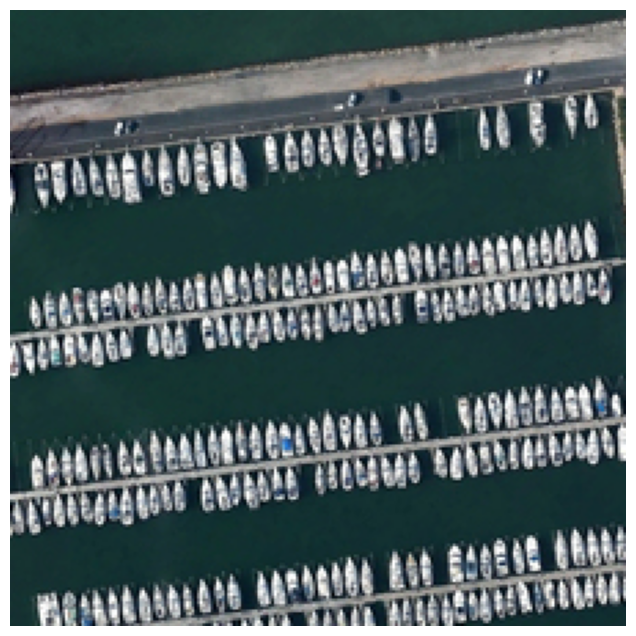

--------------------------------------------------------------------------------
IMAGE: port_340.jpg
GENERATED CAPTION:
  many white ships are parked on the port

REFERENCE CAPTIONS:
  - near the port was full of white boats
  - some trees were planted along the coast of the harbour
  - some trees were planted along the coast of the harbour
  - near the port was full of white ships
  - near the harbor was full of white ships
--------------------------------------------------------------------------------




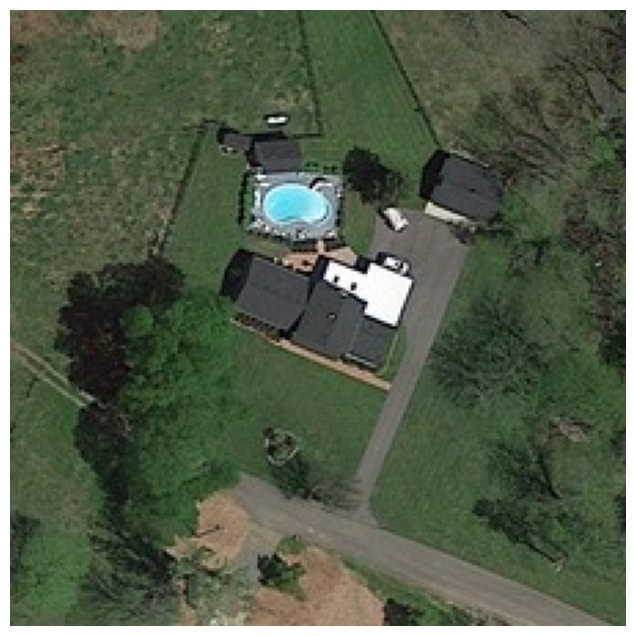

--------------------------------------------------------------------------------
IMAGE: sparseresidential_115.jpg
GENERATED CAPTION:
  a building with a swimming pool is surrounded by many green trees and meadows

REFERENCE CAPTIONS:
  - six houses with dark gray roof in the middle
  - a square pool with blue water and gray border in the middle
  - a parking lot with white pool besides the house in it
  - a residential surrounded by many green plants and a gray road in side
  - a building is surrounded by some green trees and meadows
--------------------------------------------------------------------------------




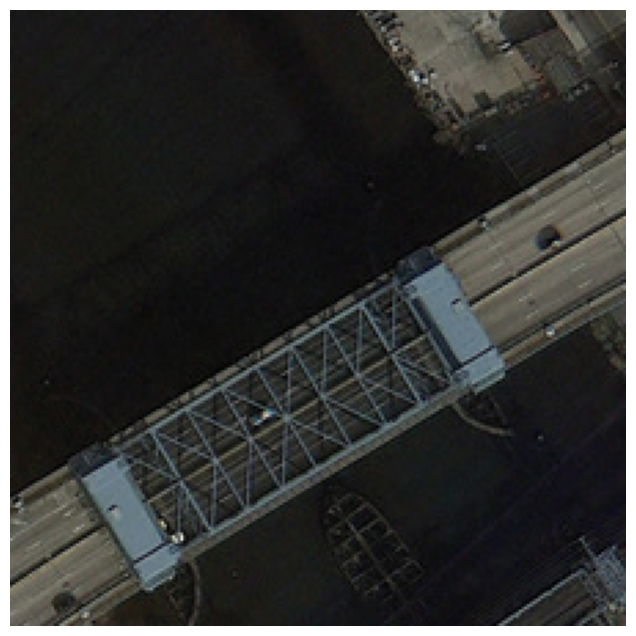

--------------------------------------------------------------------------------
IMAGE: bridge_332.jpg
GENERATED CAPTION:
  a bridge is over a river with several buildings

REFERENCE CAPTIONS:
  - there
  - s a bridge over the river there
  - s a boat on the river
  - there is a boat on the river
  - there
  - s a bridge over the river
  - there is a bridge over the river
--------------------------------------------------------------------------------




In [16]:
cfg = Config()
captions_dict = load_and_clean_captions(cfg.caption_file)
_, val_imgs, _ = create_splits(captions_dict)
model_path = '/kaggle/working/best_attention_model.pth'

print("\nDisplaying training process chart...")
plot_training_results('/kaggle/working/training_history_attention.json')

print("\nLoading trained model from checkpoint...")
checkpoint = torch.load(model_path, map_location=cfg.device, weights_only=False)
vocab = checkpoint['vocab']
encoder = EncoderCNN(finetune=False).to(cfg.device)

decoder = DecoderLSTMWithAttention(cfg.embed_size, cfg.hidden_size, len(vocab), encoder.feature_dim, cfg.attention_size).to(cfg.device)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
encoder.eval()
decoder.eval()
print("Model loaded successfully.")

show_qualitative_results_attention(
    encoder, decoder, vocab,
    img_list=val_imgs,
    img_dir=cfg.img_dir,
    captions_dict=captions_dict,
    num_samples=5
)


In [17]:
calculate_bleu_on_validation_set(
    encoder, decoder, vocab,
    img_list=val_imgs,
    img_dir=cfg.img_dir,
    captions_dict=captions_dict
)



Calculating BLEU-4 score on the full validation set...


Generating captions for BLEU score: 100%|██████████| 873/873 [00:12<00:00, 68.03it/s]



--- FINAL BLEU-4 SCORE ON VALIDATION SET: 0.4033 ---


0.4033378763311812

In [18]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-6rkb7ooo
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-6rkb7ooo
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=cd0e25664db4e033daf63ed2d0aeecbf7320e2896e199400ed9891f48e71d7c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-igo1xkli/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [19]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from torchvision import transforms
from PIL import Image
import torch, os, math
from collections import Counter

# --- optional CIDEr import ---
try:
    from pycocoevalcap.cider.cider import Cider
    use_coco = True
except ImportError:
    print("⚠️ pycocoevalcap not found. Using fallback CIDEr implementation.")
    use_coco = False


def compute_cider_fallback(references, hypotheses, n=4):
    """Simplified TF-IDF-based CIDEr implementation."""
    def ngram_counts(tokens, n):
        return Counter([tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)])

    cider_scores = []
    for refs, hyp in zip(references, hypotheses):
        ref_counts = [ngram_counts(ref, n) for ref in refs]
        hyp_count = ngram_counts(hyp, n)
        df = Counter()
        for ref in ref_counts:
            for gram in ref.keys():
                df[gram] += 1
        N = len(ref_counts)
        idf = {gram: math.log(N / (1 + df[gram])) for gram in df}
        tf_idf_hyp = {gram: hyp_count[gram] * idf.get(gram, 0) for gram in hyp_count}
        cider_score = sum(tf_idf_hyp.values()) / (len(hyp) + 1e-8)
        cider_scores.append(cider_score)
    return sum(cider_scores) / len(cider_scores)


def calculate_all_metrics(encoder, decoder, vocab, img_list, img_dir, captions_dict):
    """
    Calculates BLEU-1 to BLEU-4, METEOR, and CIDEr on validation set.
    Automatically falls back if pycocoevalcap is unavailable.
    """
    print("\n🔍 Calculating BLEU, METEOR, and CIDEr scores on the validation set...")

    references, hypotheses = [], []
    meteor_refs, meteor_hyps = [], []
    cider_refs, cider_hyps = {}, {}

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    for idx, img_name in enumerate(tqdm(img_list, desc="Generating captions for evaluation")):
        img_path = os.path.join(img_dir, img_name)
        img_tensor = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(Config.device)

        # Reference captions
        actual_caps = [cap.lower().split() for cap in captions_dict[img_name]]
        references.append(actual_caps)

        # Hypothesis
        gen_cap = generate_caption_with_attention(encoder, decoder, img_tensor, vocab)
        gen_tokens = gen_cap.lower().split()
        hypotheses.append(gen_tokens)

        # For METEOR & CIDEr
        meteor_refs.append([" ".join(ref) for ref in actual_caps])
        meteor_hyps.append(" ".join(gen_tokens))
        cider_refs[idx] = [" ".join(ref) for ref in actual_caps]
        cider_hyps[idx] = [" ".join(gen_tokens)]

    # BLEU
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    # METEOR (fixed tokenization)
    meteor_scores = [
        meteor_score([ref.split() for ref in refs], hyp.split())
        for refs, hyp in zip(meteor_refs, meteor_hyps)
    ]
    meteor = sum(meteor_scores) / len(meteor_scores)

    # CIDEr
    if use_coco:
        cider_scorer = Cider()
        cider, _ = cider_scorer.compute_score(cider_refs, cider_hyps)
    else:
        cider = compute_cider_fallback(references, hypotheses)

    print("\n📊 --- FINAL VALIDATION METRICS ---")
    print(f"BLEU-1:  {bleu1:.4f}")
    print(f"BLEU-2:  {bleu2:.4f}")
    print(f"BLEU-3:  {bleu3:.4f}")
    print(f"BLEU-4:  {bleu4:.4f}")
    print(f"METEOR:  {meteor:.4f}")
    print(f"CIDEr:   {cider:.4f}")
    print("-----------------------------------")

    return {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "CIDEr": cider
    }

In [20]:
calculate_all_metrics(
    encoder, decoder, vocab,
    img_list=val_imgs,
    img_dir=cfg.img_dir,
    captions_dict=captions_dict
)


🔍 Calculating BLEU, METEOR, and CIDEr scores on the validation set...


Generating captions for evaluation: 100%|██████████| 873/873 [00:12<00:00, 68.01it/s]



📊 --- FINAL VALIDATION METRICS ---
BLEU-1:  0.6715
BLEU-2:  0.5525
BLEU-3:  0.4702
BLEU-4:  0.4033
METEOR:  0.5719
CIDEr:   2.1585
-----------------------------------


{'BLEU-1': 0.6715180047648565,
 'BLEU-2': 0.5525339489699242,
 'BLEU-3': 0.4701768786321516,
 'BLEU-4': 0.4033378763311812,
 'METEOR': 0.571930544927037,
 'CIDEr': 2.158515077603131}

### generate caption

In [21]:
def predict_caption(encoder, decoder, vocab, image_path_or_url):
    """
    Loads an image from a path or URL, generates a caption, and displays the result.
    
    Args:
        encoder (nn.Module): The trained encoder model.
        decoder (nn.Module): The trained decoder model.
        vocab (Vocabulary): The vocabulary object from training.
        image_path_or_url (str): The local file path or web URL of the image.
    """
    try:
        
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url)
            response.raise_for_status() 
            img = Image.open(io.BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_path_or_url).convert("RGB")
            
       
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img).unsqueeze(0).to(Config.device)

        
        generated_caption = generate_caption_with_attention(encoder, decoder, img_tensor, vocab)

        
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        print("-" * 80)
        print(f"GENERATED CAPTION:\n  {generated_caption}")
        print("-" * 80)

    except requests.exceptions.RequestException as e:
        print(f"Error: Could not download image from URL. {e}")
    except FileNotFoundError:
        print(f"Error: Image file not found at path '{image_path_or_url}'")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")





print("--- LOADING TRAINED MODEL FOR INFERENCE ---")
model_path = '/kaggle/working/best_attention_model.pth'
checkpoint = torch.load(model_path, map_location=Config.device, weights_only=False)
vocab = checkpoint['vocab']

# Re-initialize models and load state dicts
encoder = EncoderCNN(finetune=False).to(Config.device)
decoder = DecoderLSTMWithAttention(Config.embed_size, Config.hidden_size, len(vocab), encoder.feature_dim, Config.attention_size).to(Config.device)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
encoder.eval()
decoder.eval()
print("Model loaded successfully.\n")



--- LOADING TRAINED MODEL FOR INFERENCE ---
Model loaded successfully.

